In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import json

In [3]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000

# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [4]:
filename2 = f"df_channels_en.tsv.gz"
channels = pd.read_csv("df_channels_en.tsv.gz", compression='gzip', sep='\t')

# We want to take the number of subscribers into account.

df = pd.merge(df, channels[['channel', 'subscribers_cc']], left_on='channel_id', right_on='channel', how='left')
df.drop(columns='channel', inplace=True)
df.head()



,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,keywords,entertainment,conspiracy,subscribers_cc
0,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:08.147047,,431.0,LDDZyDruL9w,270,3433.0,"seeker,science,curiosity,education,explain,lea...",How a Government Shutdown Screws Up Scientific...,2019-01-11 00:00:00,76663.0,trump,0,0,4140000
1,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:50.489908,,150.0,Wnv5WMsJWFE,178,3485.0,"herpes,sex,sexually transmitted,do I have herp...",Most of Us Have Herpes Thanks to Ancient Inter...,2018-03-13 00:00:00,160409.0,trump,0,0,4140000
2,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:40.363106,,97.0,oiQq9kWhGxI,229,3896.0,"NASA,global warming,climate change,melting ice...",This NASA Mission Uses Cold War Planes to Map ...,2018-02-04 00:00:00,118658.0,trump,0,0,4140000
3,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:44.269398,,542.0,uGRRvYkp6SA,274,6915.0,"global warming,climate change,trump,winter,bom...",Why Severe Winter STILL Doesn’t Disprove Globa...,2018-01-27 00:00:00,127633.0,trump,0,0,4140000
4,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:55.064292,,79.0,acuJRw004dY,169,5824.0,"moon,caves,lava tubes,exploration,colonization...","We Could Live in Caves on the Moon, Here’s Eve...",2018-01-02 00:00:00,153512.0,trump,0,0,4140000


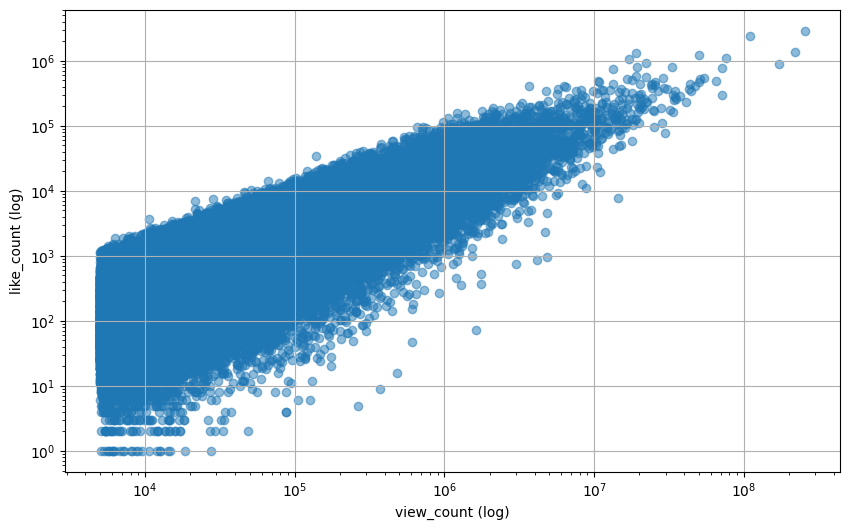

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(df['view_count'], df['like_count'], alpha=0.5)
plt.xlabel('view_count (log)')
plt.ylabel('like_count (log)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.show()

The above figure is a log-log scatter plot of likes versus views. From the graph, we can infer that the number of likes is generally positively correlated with the number of views.

 We plan to perform a linear regression on the like count using the remaining factors, assessing the impact of each factor on the like count based on their weights.

In [6]:
original_df = df.copy()

# Normalize the quatitative variables
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()
df['subscribers_cc'] = (df['subscribers_cc'] - df['subscribers_cc'].mean())/df['subscribers_cc'].std()


mod = smf.ols(formula='like_count ~ dislike_count + duration + view_count + subscribers_cc + C(entertainment) + C(conspiracy)',
              data=df)

result = mod.fit()

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 7.130e+04
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:08:13   Log-Likelihood:            -2.1798e+06
No. Observations:              208149   AIC:                         4.360e+06
Df Residuals:                  208142   BIC:                         4.360e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2252.48

In [7]:
highest_coefficient = result.params.abs().nlargest(5)
print(highest_coefficient)


view_count               11653.701820
Intercept                 2252.486058
C(conspiracy)[T.1]        1207.373814
dislike_count              925.261432
C(entertainment)[T.1]      702.863351
dtype: float64


We can see that after normalization, the positive impact of views on the like count is the largest. At the same time, whether the video is categorized as entertainment and whether it contains conspiracy theory keywords in the title or tags also have a significant positive impact on the like count. It can be seen from the p-value that the influence of these factors is significant.

Furthermore, we will explore the interaction between the factors of whether a video is categorized as entertainment and whether it contains conspiracy theory keywords in the title or tags.  We will introduce the interaction term of the two factors to perform linear regression.



In [8]:
mod2 = smf.ols(formula='like_count ~ dislike_count + duration + view_count + subscribers_cc + C(entertainment) * C(conspiracy)',
              data=df)

result2 = mod2.fit()

print(result2.summary())


                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 6.112e+04
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:            -2.1798e+06
No. Observations:              208149   AIC:                         4.360e+06
Df Residuals:                  208141   BIC:                         4.360e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Surprisingly, the coefficient of the interaction term between the two is actually negative. This means that, all else being equal, if a video is an entertainment video with conspiracy-related keywords in its title or tags, it tends to have fewer likes than entertainment videos without conspiracy keywords or non-entertainment videos with conspiracy keywords. However, the p-value of the interaction term is greater than 0.05, so this effect may not be significant.

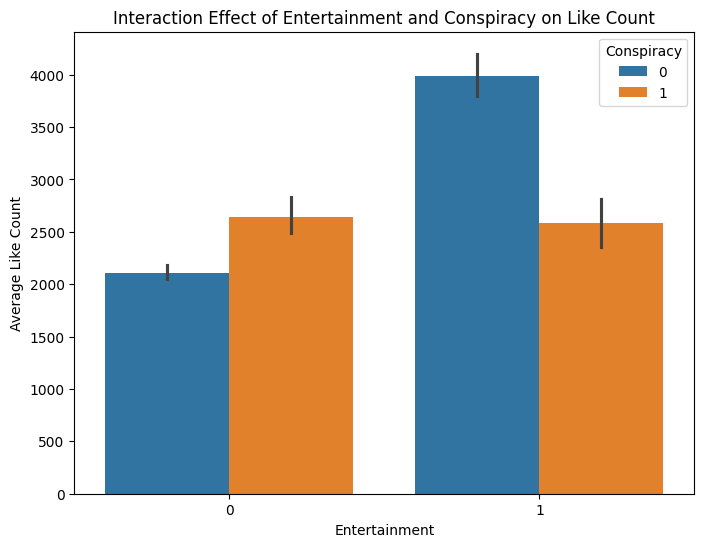

In [9]:
df['entertainment'] = df['entertainment'].astype('category')
df['conspiracy'] = df['conspiracy'].astype('category')


plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='entertainment', y='like_count', hue='conspiracy', errorbar='ci')


plt.title('Interaction Effect of Entertainment and Conspiracy on Like Count')
plt.xlabel('Entertainment')
plt.ylabel('Average Like Count')
plt.legend(title='Conspiracy')
plt.show()

 In the figure, we can see that the average number of likes for entertainment videos with conspiracy-related keywords in the title or tags is lower than that of entertainment videos without conspiracy keywords, as well as lower than that of non-entertainment videos with conspiracy keywords.

 However, this analysis is very naive because entertainment videos without conspiracy keywords may have a much larger sample size than those with conspiracy-related keywords, and the view count for videos without conspiracy keywords may be higher than that for videos with conspiracy-related keywords, leading to this phenomenon. Therefore, we hope to balance the data to verify whether the number of likes for entertainment videos without conspiracy keywords is significantly greater than that for entertainment videos with conspiracy-related keywords in the title or tags.

In [10]:
entertainment = original_df.copy()
entertainment = entertainment[entertainment['entertainment'] == 1]
entertainment.drop(columns='entertainment', inplace=True)
entertainment.head()


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,keywords,conspiracy,subscribers_cc
53,Entertainment,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:17.596725,,138.0,XFR372jg9g8,604,7986.0,"Trump,Healthcare,Obamacare,American Healthcare...",Trump Gives Update on New Healthcare Bill - Ma...,2017-07-24 00:00:00,98661.0,trump,0,1500000
61,Entertainment,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:29.676105,,616.0,UW0IvzVIUBs,258,35643.0,"Maxine Waters,Crooked Hillary,Russians,Lock He...",Maxine Waters Reveals Proof Trump is Russian A...,2017-05-19 00:00:00,637743.0,trump,0,1500000
106,Entertainment,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:36.981226,,1011.0,QEqjvwK_Y6U,117,16276.0,"2016 Election,Donald Trump,Hillary Clinton,Pre...",Celebrities Crying Over Hillary Losing Electio...,2016-11-12 00:00:00,875215.0,trump,0,1500000
132,Entertainment,UCzTTM7g6KJ1lFF9wuJCdvTg,2019-11-10 14:48:37.121053,,22.0,KkT85Uc7uO4,991,499.0,,Car Video: Commissioner Massa Says You Can’t D...,2018-05-23 00:00:00,8025.0,trump,0,40600
133,Entertainment,UCzTTM7g6KJ1lFF9wuJCdvTg,2019-11-10 14:48:53.971375,,69.0,wo3boyfLuJI,510,614.0,,Two Worlds,2018-03-20 00:00:00,9089.0,trump,0,40600


In [11]:
entertainment[entertainment['conspiracy'] == 1].view_count.describe()

count    5.190000e+02
mean     4.804467e+04
std      1.282708e+05
min      5.024000e+03
25%      1.271600e+04
50%      2.692600e+04
75%      4.733900e+04
max      2.536625e+06
Name: view_count, dtype: float64

In [12]:
entertainment[entertainment['conspiracy'] == 0].view_count.describe()

count    2.815200e+04
mean     2.303232e+05
std      1.261903e+06
min      5.000000e+03
25%      1.235175e+04
50%      2.735200e+04
75%      8.907100e+04
max      7.619722e+07
Name: view_count, dtype: float64

We can see that the average view count for entertainment videos without conspiracy keywords is nearly five times that of entertainment videos with conspiracy-related keywords in the title or tags. This may be due to the presence of more extreme values in the sample of entertainment videos without conspiracy keywords.

First, we calculate the propensity score to balance the data.

In [13]:
# Standardize the features
entertainment['dislike_count'] = (entertainment['dislike_count'] - entertainment['dislike_count'].mean())/entertainment['dislike_count'].std()
entertainment['duration'] = (entertainment['duration'] - entertainment['duration'].mean())/entertainment['duration'].std()
entertainment['view_count'] = (entertainment['view_count'] - entertainment['view_count'].mean())/entertainment['view_count'].std()
entertainment['subscribers_cc'] = (entertainment['subscribers_cc'] - entertainment['subscribers_cc'].mean())/entertainment['subscribers_cc'].std()


mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count + subscribers_cc', data=entertainment)

res = mod.fit()

# Extract the estimated propensity scores
entertainment['Propensity_score_conspiracy'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.084376
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:                28671
Model:                          Logit   Df Residuals:                    28666
Method:                           MLE   Df Model:                            4
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.06825
Time:                        18:08:15   Log-Likelihood:                -2419.2
converged:                       True   LL-Null:                       -2596.4
Covariance Type:            nonrobust   LLR p-value:                 1.943e-75
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.4976      0.169    -32.504      0.000      -5.829      -5.166
dislike_count   

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Due to the high computational complexity of matching the data, we will sample the data first.

In [14]:
conspiracy = entertainment[entertainment['conspiracy'] == 1]
non_conspiracy = entertainment[entertainment['conspiracy'] == 0]

conspiracy_sample = conspiracy.sample(frac=0.57, random_state=42) 
non_conspiracy_sample = non_conspiracy.sample(frac=0.011, random_state=42)

In [15]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

import networkx as nx

# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in non_conspiracy_sample.iterrows():
    for treatment_id, treatment_row in conspiracy_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_conspiracy'],
                                    treatment_row['Propensity_score_conspiracy'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [16]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_conspiracy = original_df.loc[original_df.index.isin(matched)]

In [17]:
conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 1]
non_conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 0]

In [18]:
conspiracy.like_count.describe()

count      296.000000
mean      2543.324324
std       2624.366803
min         15.000000
25%        795.250000
50%       1786.500000
75%       3860.500000
max      23551.000000
Name: like_count, dtype: float64

In [19]:
non_conspiracy.like_count.describe()

count      296.000000
mean      2280.084459
std       4874.140810
min          4.000000
25%        359.250000
50%        839.500000
75%       2169.750000
max      62037.000000
Name: like_count, dtype: float64

In the balanced data, the average view count for entertainment videos with conspiracy keywords is lower than the average like count for entertainment videos with conspiracy-related keywords in the title or tags.

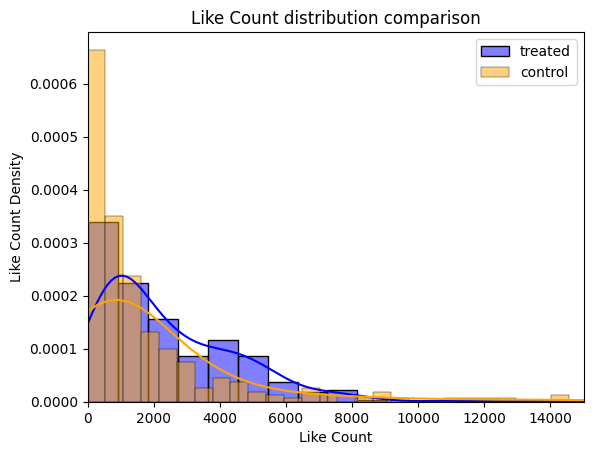

In [25]:
ax = sns.histplot(conspiracy['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_conspiracy['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count Density')
# plt.xscale('log')
plt.xlim(0,15000)
plt.legend()
plt.show()

By plotting the distribution of likes for the two groups of data, we can see that the proportion of videos with more than 2,000 likes is higher for entertainment videos with conspiracy-related keywords in the title or tags.

In [21]:
statistic, p_value = stats.mannwhitneyu(conspiracy['like_count'], non_conspiracy['like_count'], alternative='greater')

print(f"U statistic: {statistic}, p-value: {p_value}")

# Therefore, it can be considered that the median of the conspiracy theory group is significantly larger than the median of the non-conspiracy theory group on like_count.

U statistic: 56807.0, p-value: 2.0932677658570464e-10


In [22]:
# Average Treatment Effect

ATE = conspiracy['like_count'].mean() - non_conspiracy['like_count'].mean()
print(F"ATE: {ATE}")

ATE: 263.23986486486456
